In [1]:
import csv
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_v2 as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
date = '0323_setting1'
l1 = 0.3 
l2 = 0.2
m1 = 3
m2 = 2
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
#setting number 5 약간 꼬불꼬불?
xpoints = np.array([  0.5,1.5,2.0,1.5,1.0,2.0])
ypoints = np.array([  0.5,0.8,1.1,1.4,1.7,2.0])
Vpoints = np.array([  1.5,1.7,1.9,2.3,2.6])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints,Vpoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 500
V_size = 300
V_hidden_sizes = [V_size, V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.01
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 0#100000
alpha_kinematic = 0.01
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

In [13]:

date = '0324_setting1'

In [14]:
f = open(date+'_total_data.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['xpoints'])
wr.writerow(xpoints)
wr.writerow(['ypoints'])
wr.writerow(ypoints)
wr.writerow(['T = ',T])
wr.writerow(['delta = ',delta])
wr.writerow(['num_timesteps = ',num_timesteps])
f.close()

In [4]:
a,b,c,d,e = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)

#1 done
#2 done
#3 done
#4 done
#5 done


In [5]:
a,b,c,d,e

(tensor(8.6652, device='cuda:0'),
 tensor(2.6572, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(1.5068),
 tensor(0.0278, device='cuda:0'),
 tensor(0.0594, device='cuda:0'))

In [ ]:
print(a,b,c,d,e)

# Ploting trajectory

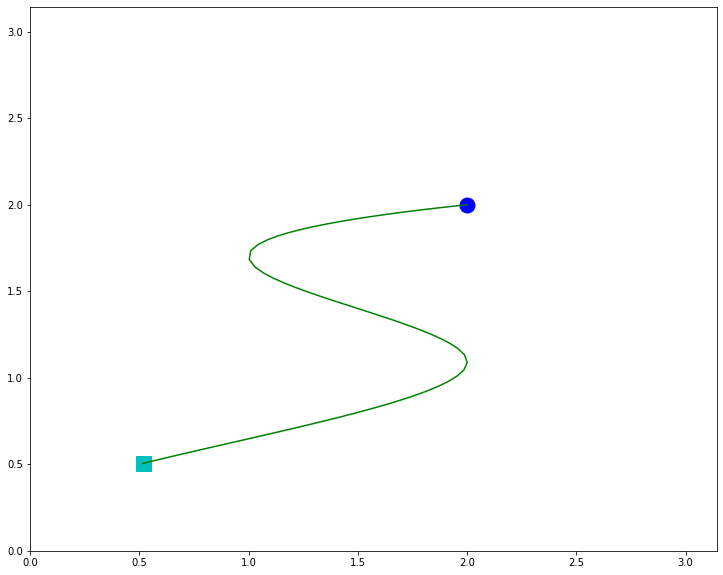

In [6]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

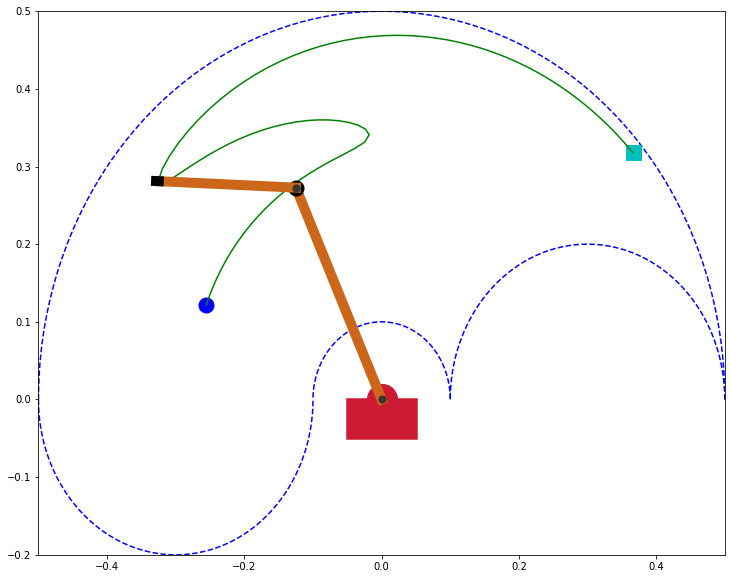

In [7]:
theta1 = xpoints[2]
theta2 = ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [12]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [18]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 4055, loss = 0.0002422941, loss_b = 1.5586475, loss_t = 0.0002422941                    . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [19]:
loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_1, loss_boundary_1, loss_Euc_1, loss_kinematic_1, loss_kinetic_1)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0024, device='cuda:0') tensor(14.0507, device='cuda:0', grad_fn=<MulBackward0>) tensor(8349.0840) tensor(103.2676, device='cuda:0') tensor(378.5598, device='cuda:0')


In [20]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['No Regularization'])
wr.writerow(['loss_traj_1', 'loss_boundary_1', 'loss_Euc_1', 'loss_kinematic_1', 'loss_kinetic_1'])
wr.writerow([loss_traj_1.data.to(device_c).numpy(), loss_boundary_1.data.to(device_c).numpy(), loss_Euc_1.data.to(device_c).numpy(), loss_kinematic_1.data.to(device_c).numpy(), loss_kinetic_1.data.to(device_c).numpy()])
f.close()

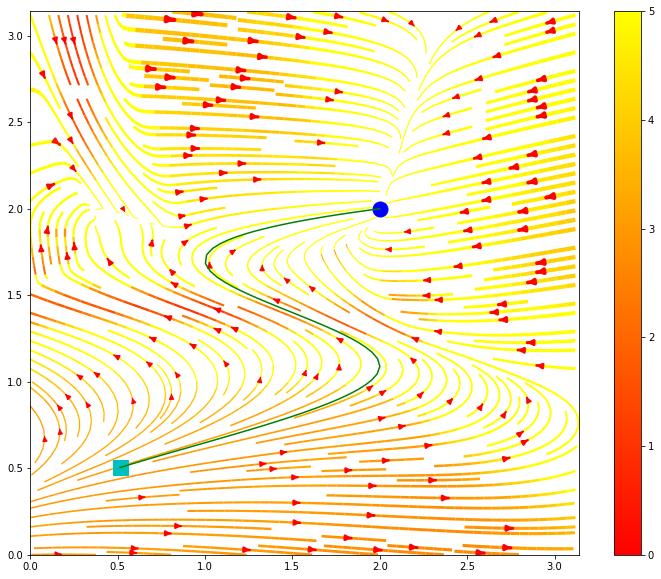

In [21]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

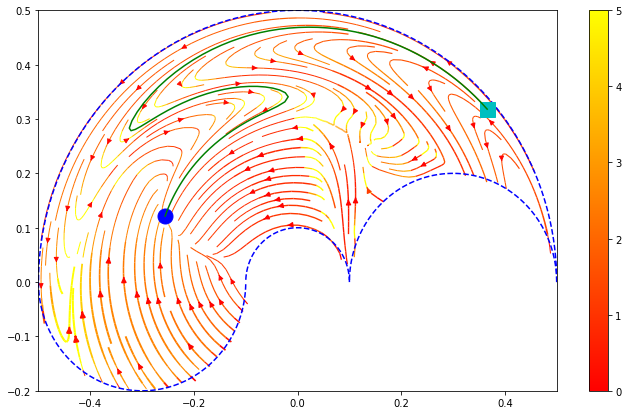

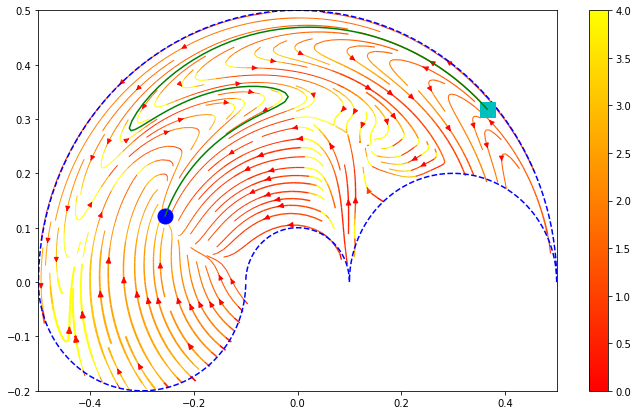

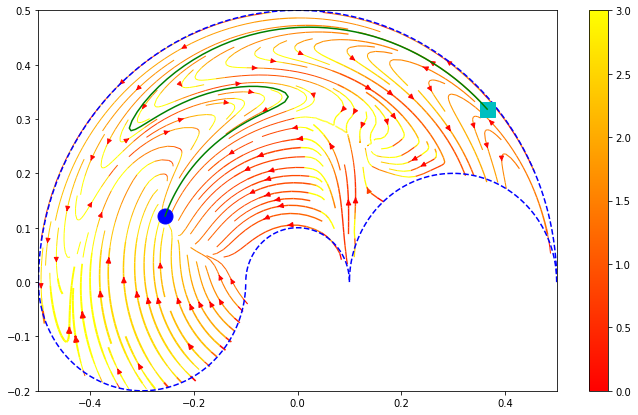

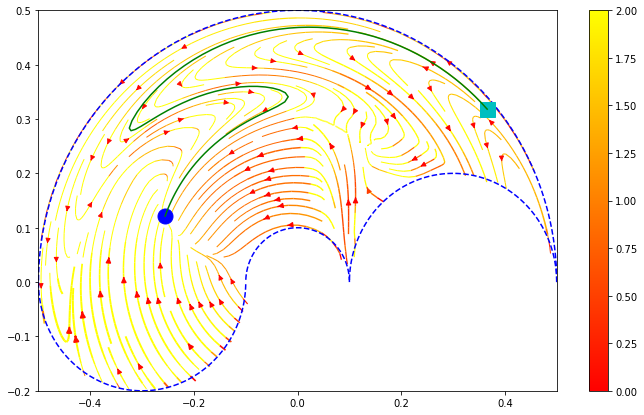

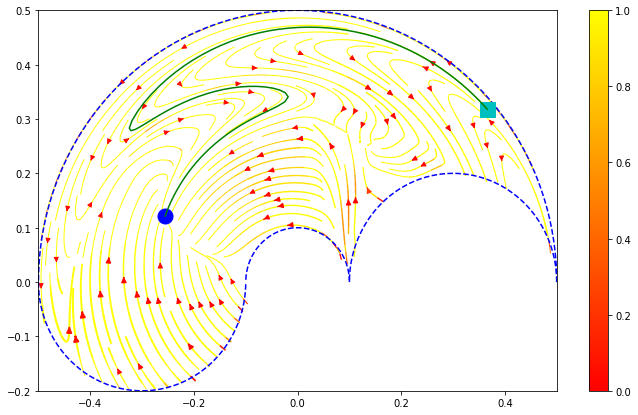

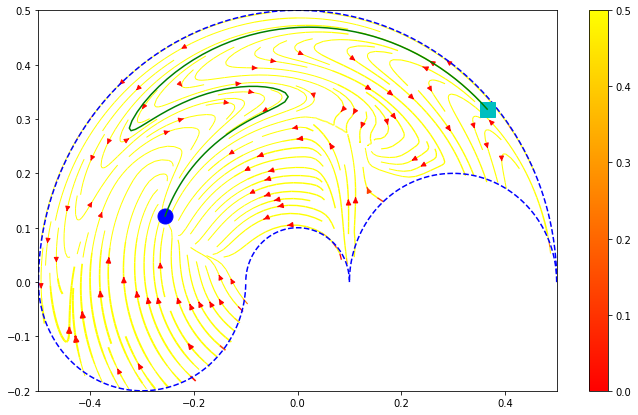

In [23]:
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_noreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

## weight norm decay

In [53]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [54]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 1709, loss = 0.010143786, loss_b = 0.0, loss_t = 0.010143786                    . .      .  .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

KeyboardInterrupt: 

In [24]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 10000, loss = 0.0001999304, loss_b = 1.1756556, loss_t = 0.0001999304                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [25]:
loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_2, loss_boundary_2, loss_Euc_2, loss_kinematic_2, loss_kinetic_2)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0019, device='cuda:0') tensor(10.5900, device='cuda:0', grad_fn=<MulBackward0>) tensor(1292.8586) tensor(16.1976, device='cuda:0') tensor(29.0646, device='cuda:0')


In [26]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Weight Regularization'])
wr.writerow(['loss_traj_2', 'loss_boundary_2', 'loss_Euc_2', 'loss_kinematic_2', 'loss_kinetic_2'])
wr.writerow([loss_traj_2.data.to(device_c).numpy(), loss_boundary_2.data.to(device_c).numpy(), loss_Euc_2.data.to(device_c).numpy(), loss_kinematic_2.data.to(device_c).numpy(), loss_kinetic_2.data.to(device_c).numpy()])
f.close()

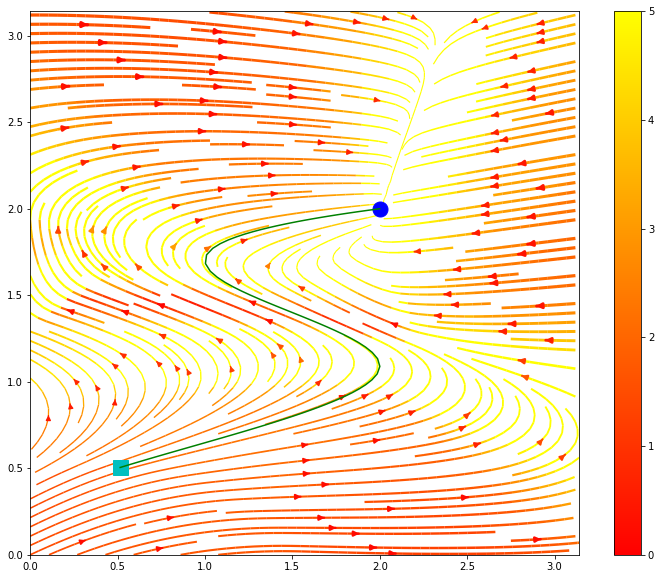

In [27]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

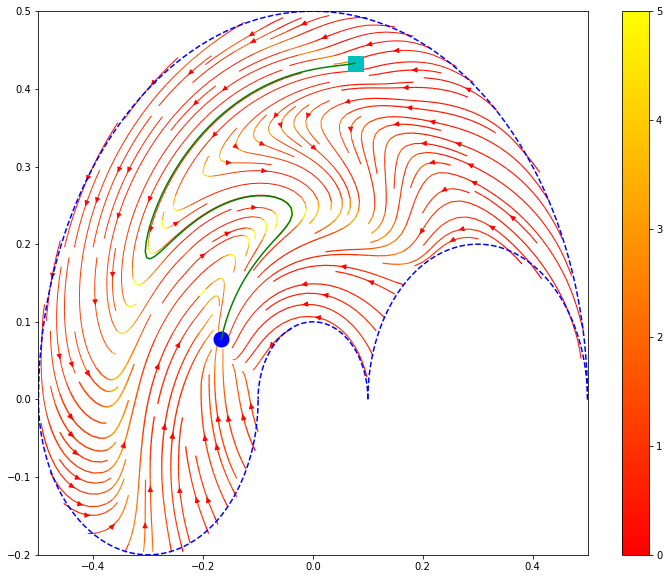

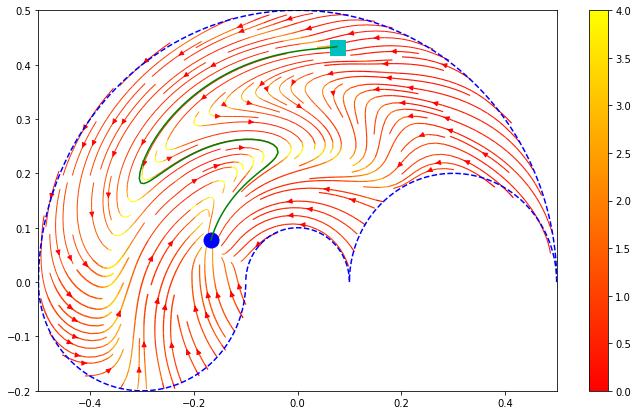

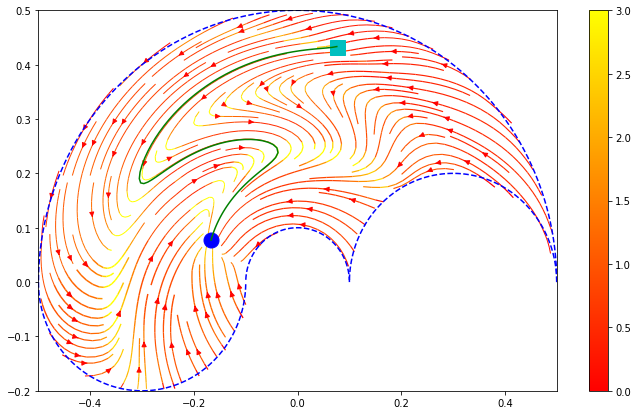

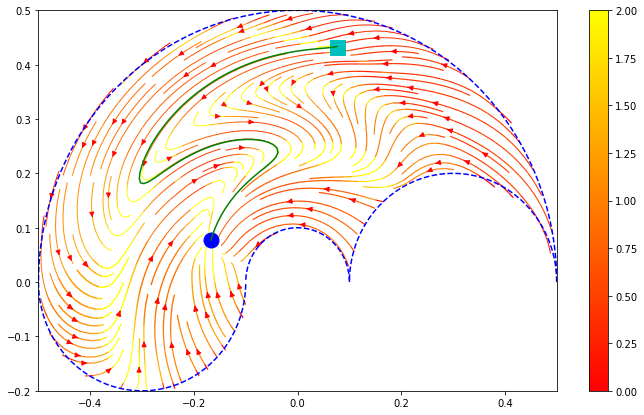

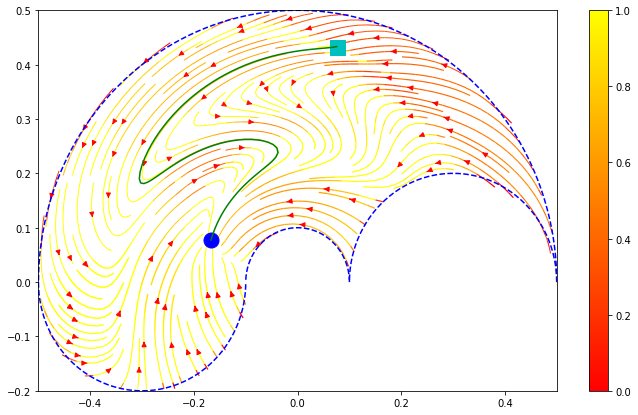

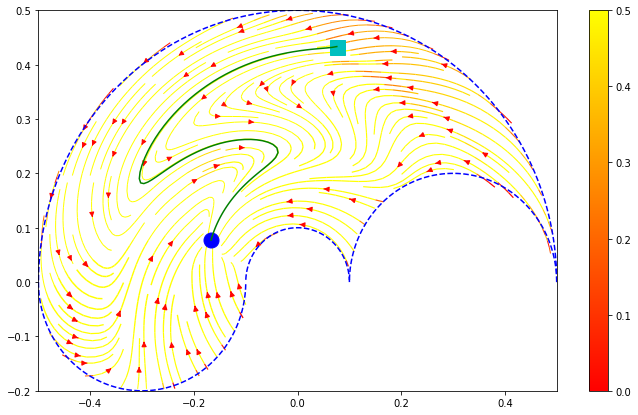

In [59]:
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_wreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Euclidean Regularization

In [6]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [7]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 1480, loss = 0.0019863595, loss_b = 2.1896492e-05, loss_t = 0.001986359                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

In [7]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 3809, loss = 0.00017975969, loss_b = 0.0, loss_t = 0.00017975969                    .        ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [34]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
penalty = 50
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 1e-5,epoch=10000, batch_size = 40,penalty_mode = mode)

 i = 10000, loss = 67.085526, total_loss = 105.85747, loss_t = 0.008756514, loss_reg = 7.229938, loss_reg_total =  45.99172           ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [35]:
loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_3, loss_boundary_3, loss_Euc_3, loss_kinematic_3, loss_kinetic_3)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0779, device='cuda:0') tensor(13.2867, device='cuda:0', grad_fn=<MulBackward0>) tensor(413.1338) tensor(3.6532, device='cuda:0') tensor(6.8894, device='cuda:0')


In [36]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Euclidean Regularization'])
wr.writerow(['loss_traj_3', 'loss_boundary_3', 'loss_Euc_3', 'loss_kinematic_3', 'loss_kinetic_3'])
wr.writerow([loss_traj_3.data.to(device_c).numpy(), loss_boundary_3.data.to(device_c).numpy(), loss_Euc_3.data.to(device_c).numpy(), loss_kinematic_3.data.to(device_c).numpy(), loss_kinetic_3.data.to(device_c).numpy()])
f.close()

PermissionError: [Errno 13] Permission denied: '0323_setting1_total_data.csv'

In [ ]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Eucreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

In [ ]:
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_Eucreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinematic Regularization

In [6]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [8]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000)

 epoch = 1459, loss = 0.00043299067, loss_b = 1.1730992, loss_t = 0.00043299067                    .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [17]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared

penalty = 10
penalty_boundary = 0
mode = 2
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 1e-5,epoch=150000, batch_size = 40,penalty_mode = mode)

 i = 8059, loss = 11.553571, total_loss = 11.661859, loss_b = 2.4169395, loss_t = 0.00013771601, loss_reg = 0.03375499, loss_reg_total =  0.14558841           .. ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [18]:
loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_4, loss_boundary_4, loss_Euc_4, loss_kinematic_4, loss_kinetic_4)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0009, device='cuda:0') tensor(21.9489, device='cuda:0', grad_fn=<MulBackward0>) tensor(581.5660) tensor(1.7952, device='cuda:0') tensor(4.1888, device='cuda:0')


In [15]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinematic Regularization'])
wr.writerow(['loss_traj_4', 'loss_boundary_4', 'loss_Euc_4', 'loss_kinematic_4', 'loss_kinetic_4'])
wr.writerow([loss_traj_4.data.to(device_c).numpy(), loss_boundary_4.data.to(device_c).numpy(), loss_Euc_4.data.to(device_c).numpy(), loss_kinematic_4.data.to(device_c).numpy(), loss_kinetic_4.data.to(device_c).numpy()])
f.close()

NameError: name 'loss_traj_4' is not defined

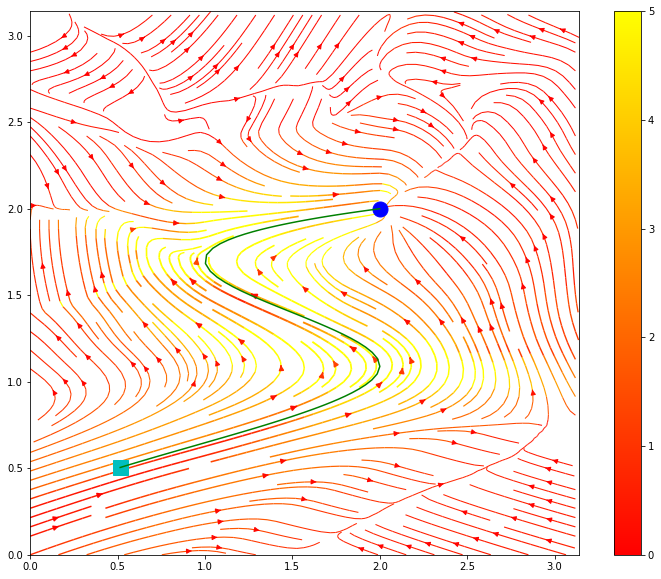

In [20]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kinematicreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

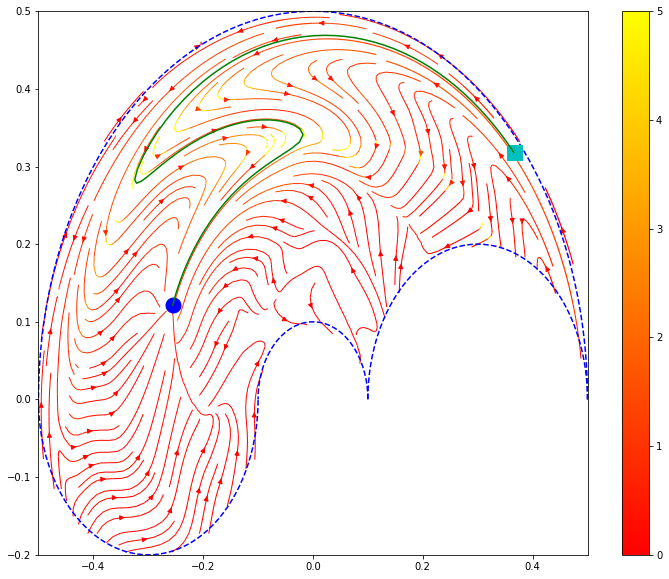

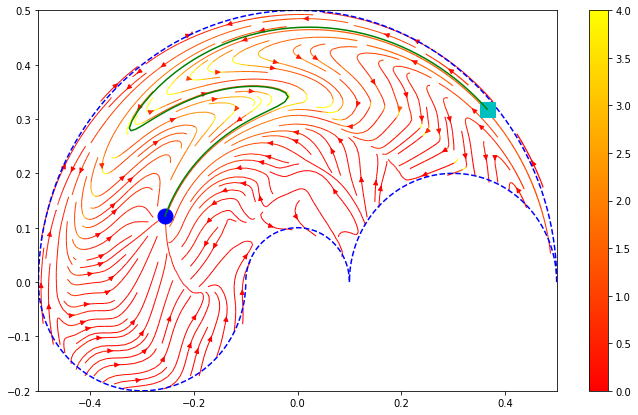

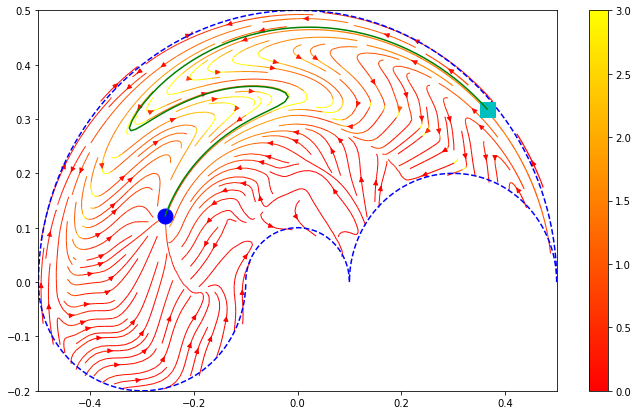

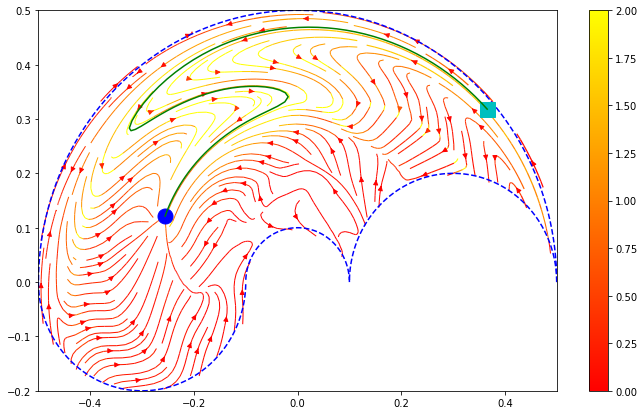

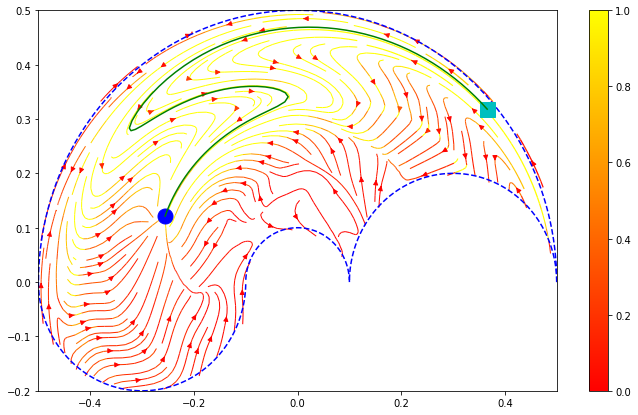

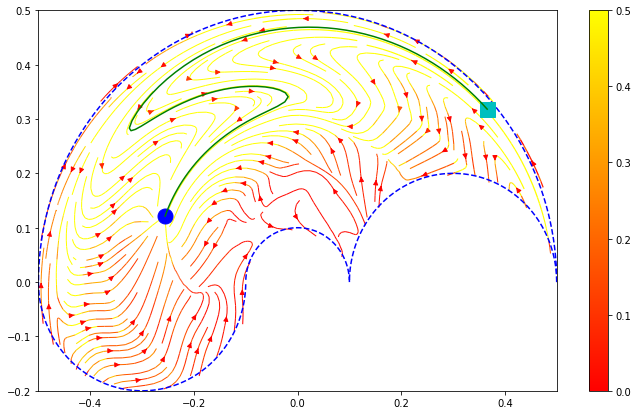

In [21]:
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kinematicreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

# Kinetic Regularization

In [3]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device,T)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [4]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 4e-4 ,epoch=10000)

 epoch = 10000, loss = 0.00060057634, loss_b = 0.99428385, loss_t = 0.00060057634                    .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [6]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
penalty = 10
penalty_boundary = 0
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-5,epoch=150000, batch_size = 40,penalty_mode = 2)

 i = 91, loss = 12.000476, total_loss = 11.78573, loss_b = 0.8554973, loss_t = 0.0001830945, loss_reg = 0.47838733, loss_reg_total =  0.26364103           .   .                                                                                     

KeyboardInterrupt: 

In [7]:
loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5 = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)
print(loss_traj_5, loss_boundary_5, loss_Euc_5, loss_kinematic_5, loss_kinetic_5)

#1 done
#2 done
#3 done
#4 done
#5 done
tensor(0.0016, device='cuda:0') tensor(8.5591, device='cuda:0', grad_fn=<MulBackward0>) tensor(490.7654) tensor(1.5971, device='cuda:0') tensor(3.6089, device='cuda:0')


In [16]:
f = open(date+'_total_data.csv','a', newline='')
wr = csv.writer(f)
wr.writerow(['Kinetic Regularization'])
wr.writerow(['loss_traj_5', 'loss_boundary_5', 'loss_Euc_5', 'loss_kinematic_5', 'loss_kinetic_5'])
wr.writerow([loss_traj_5.data.to(device_c).numpy(), loss_boundary_5.data.to(device_c).numpy(), loss_Euc_5.data.to(device_c).numpy(), loss_kinematic_5.data.to(device_c).numpy(), loss_kinetic_5.data.to(device_c).numpy()])
f.close()

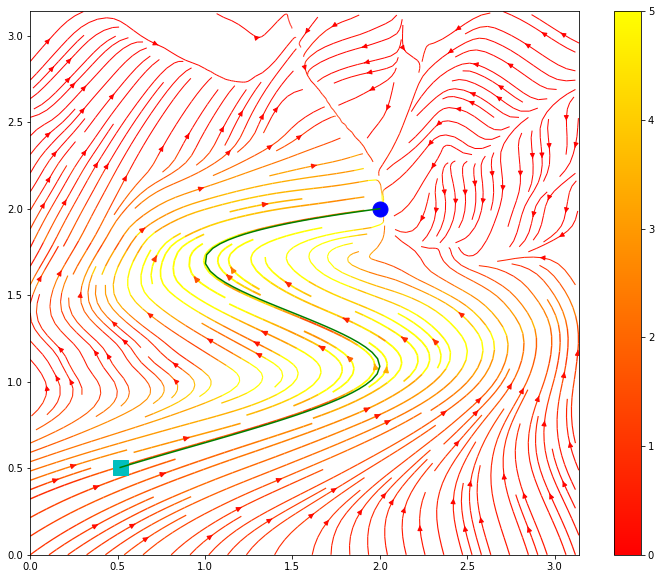

In [9]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kineticreg_'+date+'.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\ICNN_plot.py:103: RuntimeWarning: invalid value encountered in arccos
  q1 = np.arccos(((self.l1+self.l2*np.cos(q2))*x1+(self.l2*np.sin(q2))*x2)/(self.l1**2+self.l2**2+2*self.l1*self.l2*np.cos(q2)))


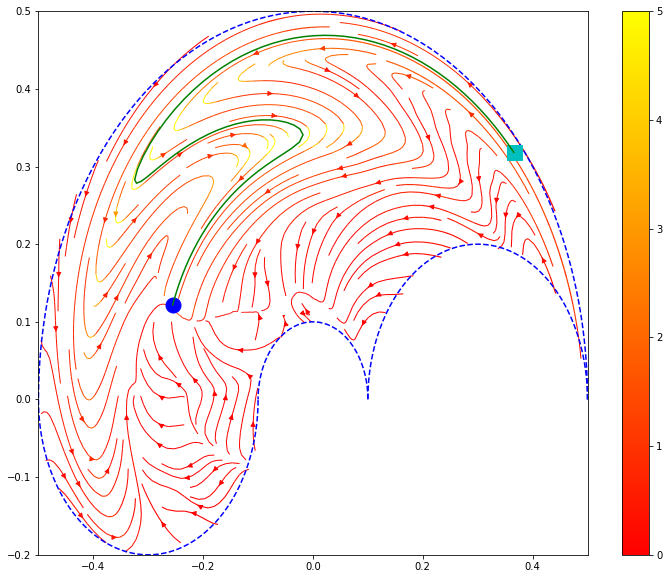

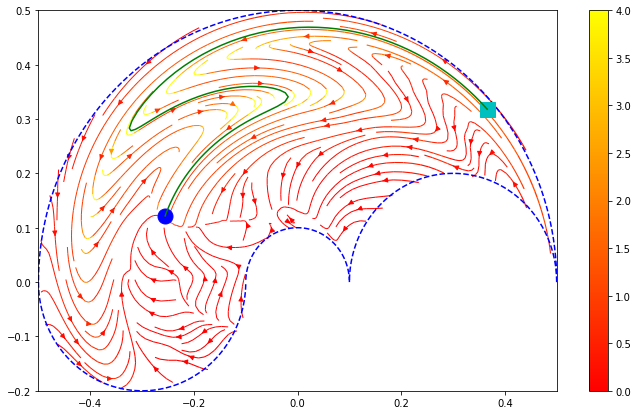

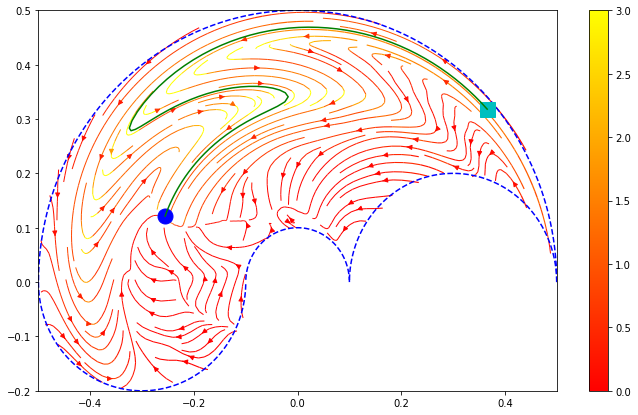

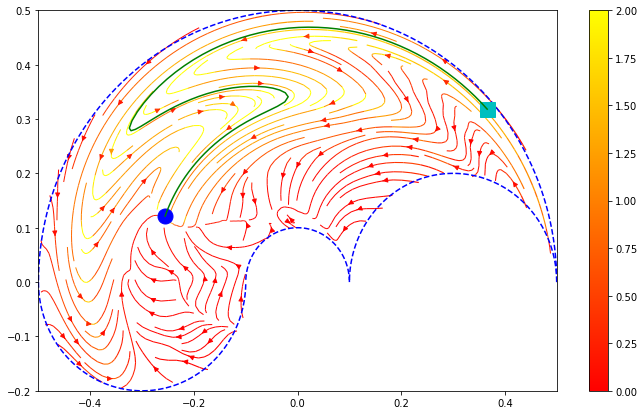

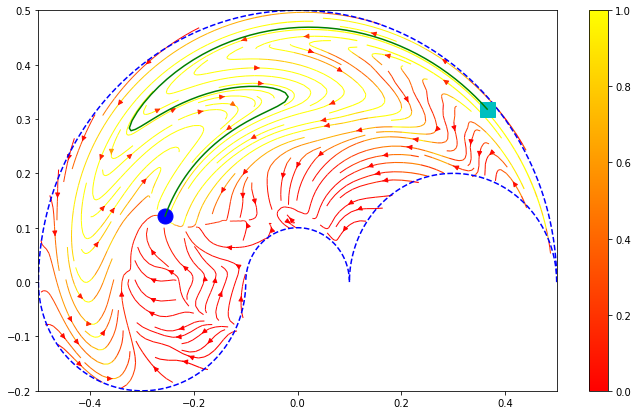

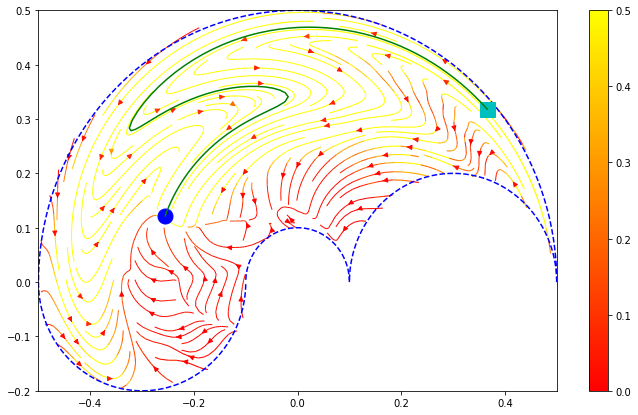

In [10]:
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_5.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_4.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=4)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_3.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=3)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_2.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=2)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)
plt_.plot_f_taskspace('task_plot_kineticreg_'+date+'_05.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=.5)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

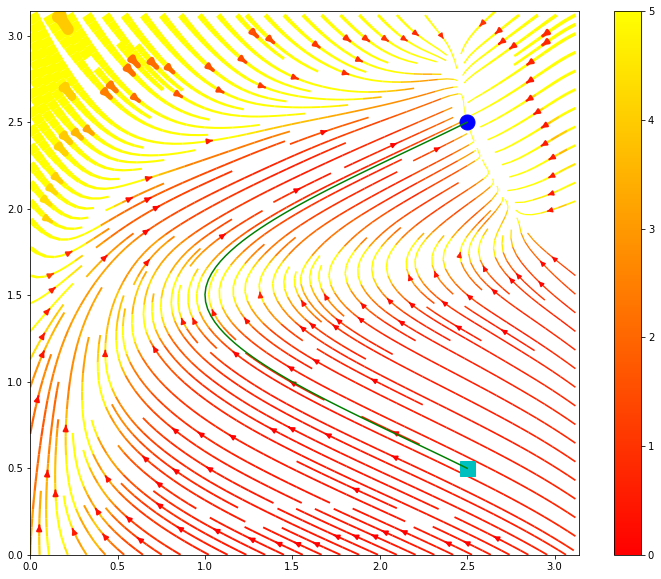

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

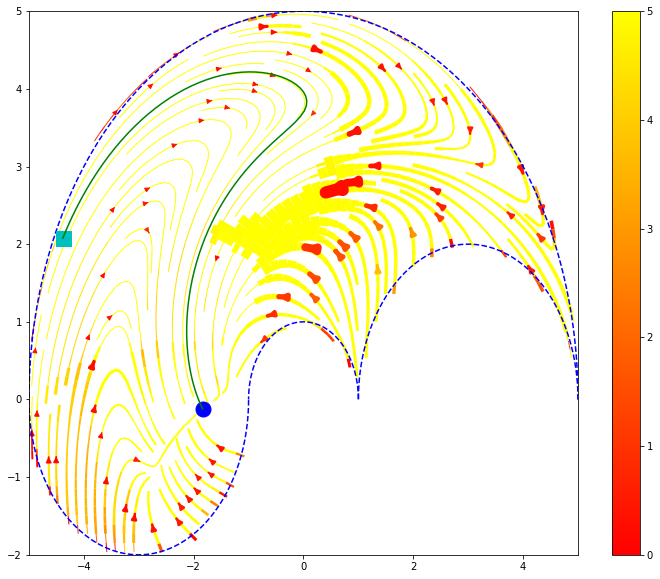

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'